In [199]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import sqrt
import pandas as pd
import scipy.constants as const
from scipy.optimize import fsolve
from scipy.optimize import curve_fit                        # Funktionsfit:     popt, pcov = curve_fit(func, xdata, ydata) 
from uncertainties import ufloat                            # Fehler:           fehlerwert =  ulfaot(x, err)
from uncertainties import unumpy as unp 
from uncertainties.unumpy import uarray                     # Array von Fehler: fehlerarray =  uarray(array, errarray)
from uncertainties.unumpy import (nominal_values as noms,   # Wert:             noms(fehlerwert) = x
                                  std_devs as stds)         # Abweichung:       stds(fehlerarray) = errarray

Tabelle erstellen:

In [200]:
Ua = pd.read_csv('tables/spannung.csv')
print(Ua.to_latex(index = False, column_format= "c c", decimal=',')) 

\begin{tabular}{c c}
\toprule
 f/kHz &   U/V \\
\midrule
  20,0 & 0,085 \\
  22,5 & 0,110 \\
  25,0 & 0,150 \\
  27,0 & 0,190 \\
  30,0 & 0,310 \\
  32,8 & 0,800 \\
  33,3 & 1,200 \\
  34,1 & 1,900 \\
  35,4 & 2,000 \\
  36,0 & 1,600 \\
  36,9 & 0,840 \\
  38,3 & 0,530 \\
  39,3 & 0,410 \\
\bottomrule
\end{tabular}



Daten auswerten:

33.50+/-0.14 36.41+/-0.14


(-0.05, 1.05)

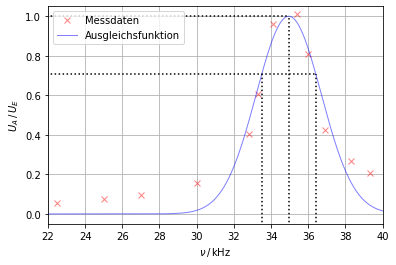

In [248]:
np.savetxt('tables/Ua.txt', Ua.values, header='f/Hz U/V', fmt='%.3f')
nu, U = np.genfromtxt('tables/Ua.txt', unpack=True, skip_header=1)
U = U/(2*0.9892978920131985)

plt.plot(nu, U, 'xr', markersize=6 , label = 'Messdaten', alpha=0.5)

# für den initial guess bei curvefit()
n = len(nu)                              #the number of data
mean = sum(nu*U)/n                       #note this correction
# sigma = sum(U*(nu - mean)**2)/n        #note this correction
sigma = np.sqrt(sum(U*(nu - mean)**2))

# Ausgleichsrechung nach Gaußverteilung
def g(x,a,x0,b):
    return a*np.exp(-(x-x0)**2/(b)) # b = 2*sigma**2

para, pcov = curve_fit(g, nu, U, p0=[1,mean,sigma])
a, nu0, b = para
pcov = np.sqrt(np.diag(pcov))
fa, fnu0, fb = pcov
ua = ufloat(a, fa) 
ub = ufloat(b, fb)
unu0 = ufloat(nu0, fnu0)

xx = np.linspace(18, 42, 10**4)
plt.plot(xx, g(xx, *para), '-b', linewidth = 1, label = 'Ausgleichsfunktion', alpha=0.5)

# \nu_+- für U_A/U_E = 1/sqrt(2)
nu_m = nu0 - np.sqrt(-b*np.log(1/(a*np.sqrt(2))))
fnu_m = fnu0 #- np.sqrt(-fb*np.log(1/(fa*np.sqrt(2))))
unu_m = ufloat(nu_m, fnu_m)

nu_p = nu0 + np.sqrt(-b*np.log(1/(a*np.sqrt(2))))
fnu_p = fnu0
unu_p = ufloat(nu_p, fnu_p)
print(unu_m, unu_p)


plt.vlines(nu_m, -1, g(nu_m, *para), linestyle='dotted', colors='black')
plt.vlines(nu_p, -1, g(nu_p, *para), linestyle='dotted', colors='black')
plt.hlines(g(nu_m, *para), 0, nu_p,  linestyle='dotted', colors='black')

plt.vlines(nu0, -1, g(nu0, *para), linestyle='dotted', colors='black')
plt.hlines(g(nu0, *para), 0, nu0,  linestyle='dotted', colors='black')

# x = [nu_m, nu0, nu_p]
# x_labels = [r'$\nu_{-}$', r'$\nu_{0}$', r'$\nu_{+}$']
# plt.xticks(ticks=x, labels=x_labels)
# plt.xlabels()

# plt.axvline(x=nu_m, color='gray', linestyle='--')
# plt.axhline(y=g(nu_m, *para), color='gray', linestyle='--')

# plt.annotate(r'$\frac{1}{\sqrt{2}}$', xy=(35, 0.7), xycoords = 'data', textcoords = 'offset pixels')

plt.xlabel(r'$\nu \, / \, \mathrm{kHz}$')
plt.ylabel(r'$U_A \, / \, U_E$')
plt.legend(loc="best")                  # legend position
plt.grid(True)                          # grid style
plt.xlim(22, 40)
plt.ylim(-0.05, 1.05)


Fehler berechnen:

In [202]:
print('a =', ua)
print('b =', ub)
print('nu_m =', unu_m)
print('nu0 =', unu0)
print('nu_p =', unu_p)
print('U0 =', g(nu0, a, nu0, b))

a = 0.99+/-0.07
b = 6.1+/-1.2
nu_m = 33.52+/-0.14
nu0 = 34.95+/-0.14
nu_p = 36.38+/-0.14
U0 = 0.9892978920131985


Güte des Selektivverstärkers:

In [250]:
Q = unu0 / (unu_p - unu_m)
print(Q)
delta_Q = 100 *abs(Q - 20)/20
print(delta_Q)

12.0+/-0.8
40+/-4


Querschnitt der Proben berechnen:

In [203]:
d_m = 15.10; d_l = 15.9; d_rho = 7.80 #g/cm^3
g_m = 14.08; g_l = 16.5; g_rho = 7.40
n_m =  8.48; n_l = 16.5; n_rho = 7.24

def Q(m, l ,rho):
    return m/(l*rho)

d_Q = Q(d_m, d_l, d_rho)
g_Q = Q(g_m, g_l, g_rho)
n_Q = Q(n_m, n_l, n_rho)

m = [d_m, g_m, n_m]
l = [d_l, g_l, n_l]
rho = [d_rho, g_rho, n_rho]
Q = np.array([d_Q, g_Q, n_Q])
stoffe = ['Dy2O3', 'Gd2O3', 'Nd2O3']

f = {'Stoff': stoffe, 'm/g': m, 'l/cm': l, 'rho_w/g/cm**3': rho, 'Q/cm**2': Q}
df = pd.DataFrame(data = f)
print(df.to_latex(index = False, column_format= "c c c c", decimal=',')) 


\begin{tabular}{c c c c}
\toprule
Stoff &   m/g &  l/cm &  rho\_w/g/cm**3 &  Q/cm**2 \\
\midrule
Dy2O3 & 15,10 &  15,9 &           7,80 & 0,121755 \\
Gd2O3 & 14,08 &  16,5 &           7,40 & 0,115315 \\
Nd2O3 &  8,48 &  16,5 &           7,24 & 0,070986 \\
\bottomrule
\end{tabular}



Anzahl der Momente $N$ berechnen:

In [204]:
d_mol = 373; g_mol = 362.5; n_mol = 336.48
def N(rho, M_mol):
    return 2 * const.Avogadro * (rho/M_mol)

print(const.Avogadro)

d_N = N(d_rho, d_mol) 
g_N = N(n_rho, g_mol)
n_N = N(n_rho, n_mol)
M_mol = [d_mol, g_mol, n_mol]
N = np.array([d_N, g_N, n_N])
f = {'Stoff': stoffe, 'rho/g/cm**3': rho, 'M_mol/g/mol': M_mol, 'N/1/cm**3 * 10**22': N*1e-22}
df = pd.DataFrame(data = f)
print(df.to_latex(index = False, column_format= "c c c c", decimal=','))

6.02214076e+23
\begin{tabular}{c c c c}
\toprule
Stoff &  rho/g/cm**3 &  M\_mol/g/mol &  N/1/cm**3 * 10**22 \\
\midrule
Dy2O3 &         7,80 &       373,00 &            2,518643 \\
Gd2O3 &         7,40 &       362,50 &            2,405534 \\
Nd2O3 &         7,24 &       336,48 &            2,591554 \\
\bottomrule
\end{tabular}



Messdaten der Stoffe auswerten:

In [205]:
# Dy2 O3
dy = pd.read_csv('tables/dy.csv')
np.savetxt('tables/dy.txt', dy.values, header='Uv Rv Uv Rn', fmt='%.3f')
d_Uv, d_Rv, d_Un, d_Rn = np.genfromtxt('tables/dy.txt', unpack=True, skip_header=1)
d_Rv *= 0.005; d_Rn *= 0.005
d_delR = d_Rv - d_Rn
d_delU = d_Uv - d_Un
print(np.mean(d_delU))

dy = {'Uv':d_Uv, 'Rv':d_Rv, 'Un':d_Un, 'Rn':d_Rn, 'deltaU':d_delU, 'deltaR':d_delR}
df_dy = pd.DataFrame(data = dy)
print(df_dy.to_latex(index = False, column_format= "c c c c c c", decimal=',')) 

5.153333333333333
\begin{tabular}{c c c c c c}
\toprule
 Uv &    Rv &   Un &    Rn &  deltaU &  deltaR \\
\midrule
5,5 & 3,405 & 0,40 & 1,855 &    5,10 &   1,550 \\
5,6 & 3,330 & 0,33 & 1,825 &    5,27 &   1,505 \\
5,4 & 3,330 & 0,31 & 1,830 &    5,09 &   1,500 \\
\bottomrule
\end{tabular}



In [206]:
# Gd2 O3
gd = pd.read_csv('tables/gd.csv')
np.savetxt('tables/gd.txt', gd.values, header='Uv Rv Uv Rn', fmt='%.3f')
g_Uv, g_Rv, g_Un, g_Rn = np.genfromtxt('tables/gd.txt', unpack=True, skip_header=1)
g_Rv *= 0.005; g_Rn *= 0.005
g_delR = g_Rv - g_Rn
g_delU = g_Uv - g_Un

gd = {'Uv':g_Uv, 'Rv':g_Rv, 'Un':g_Un, 'Rn':g_Rn, 'deltaU':g_delU, 'deltaR':g_delR}
df_gd = pd.DataFrame(data = gd)
print(df_gd.to_latex(index = False, column_format= "c c c c c c", decimal=','))

\begin{tabular}{c c c c c c}
\toprule
 Uv &    Rv &   Un &   Rn &  deltaU &  deltaR \\
\midrule
2,5 & 3,370 & 0,29 & 2,69 &    2,21 &   0,680 \\
2,8 & 3,355 & 0,28 & 2,64 &    2,52 &   0,715 \\
2,7 & 3,370 & 0,26 & 2,68 &    2,44 &   0,690 \\
\bottomrule
\end{tabular}



In [207]:
# Nd2 O3
nd = pd.read_csv('tables/nd.csv')
np.savetxt('tables/nd.txt', nd.values, header='Uv Rv Uv Rn', fmt='%.3f')
n_Uv, n_Rv, n_Un, n_Rn = np.genfromtxt('tables/nd.txt', unpack=True, skip_header=1)
n_Rv *= 0.005; n_Rn *= 0.005
n_delR = n_Rv - n_Rn
n_delU = n_Uv - n_Un

nd = {'Uv':n_Uv, 'Rv':n_Rv, 'Un':n_Un, 'Rn':n_Rn, 'deltaU':n_delU, 'deltaR':n_delR}
df_nd = pd.DataFrame(data = nd)
print(df_nd.to_latex(index = False, column_format= "c c c c c c", decimal=','))

\begin{tabular}{c c c c c c}
\toprule
   Uv &    Rv &   Un &    Rn &  deltaU &  deltaR \\
\midrule
0,440 & 3,340 & 0,38 & 3,305 &   0,060 &   0,035 \\
0,425 & 3,380 & 0,36 & 3,285 &   0,065 &   0,095 \\
0,510 & 3,405 & 0,34 & 3,315 &   0,170 &   0,090 \\
\bottomrule
\end{tabular}



Suszeptibiltäten berechnen:

In [208]:
F = 86.6 / 100  # Querschnitt der Spule im cm^2
Q = Q           # von oben
U_sp = 1        # Speisespannung = 1 ?

U = np.array([np.mean(d_delU), np.mean(g_delU), np.mean(n_delU)])
U /= 1000

def chi_U(U):
    return 4 * (F/Q) * (U/U_sp)

chi_U = chi_U(U)

R3 = 998        # ohm
def chi_R(R):
    return 2 * (F/Q) * (R/R3)

R = np.array([np.mean(d_delR), np.mean(g_delR), np.mean(n_delR)])
chi_R = chi_R(R)

N_a = const.Avogadro
mu_0 = const.mu_0
mu_b = const.physical_constants['Bohr magneton'][0]
k_b = const.Boltzmann
print(mu_0)
T = 293                 # Raumtemperatur
def chi_theo(N, g_j, J):
    return (mu_0 * mu_b**2 * np.square(g_j) * N * J*(J+1))/(3 * k_b * T)

J = np.array([7.5, 3.5, 4.5])       # Gesamtdrehimpulse Dy, Gd, Nd
g_j = np.array([4/3, 2, 8/11])      # Landre-Faktoren ''

chi_theo = chi_theo(N, g_j, J)
chi_theo *= 1e6                      # sehr illegal

f = {'Stoff': stoffe, 'chi_U': chi_U, 'chi_R': chi_R, 'chie_theo': chi_theo}
df = pd.DataFrame(data = f)
print(df.to_latex(index = False, column_format= "c c c c", decimal=','))

1.25663706212e-06
\begin{tabular}{c c c c}
\toprule
Stoff &    chi\_U &    chi\_R &  chie\_theo \\
\midrule
Dy2O3 & 0,146616 & 0,021642 &   0,025421 \\
Gd2O3 & 0,071794 & 0,010460 &   0,013497 \\
Nd2O3 & 0,004798 & 0,001793 &   0,003021 \\
\bottomrule
\end{tabular}



Relative Abweichung:

In [209]:
delta_chi_U = 100 *abs(chi_U - chi_theo)/chi_theo
delta_chi_R = 100 *abs(chi_R - chi_theo)/chi_theo

f = {'Stoff': stoffe, 'delta chi_U': delta_chi_U, 'delta chi_R': delta_chi_R}
df = pd.DataFrame(data = f)
print(df.to_latex(index = False, column_format= "c c c", decimal=','))

\begin{tabular}{c c c}
\toprule
Stoff &  delta chi\_U &  delta chi\_R \\
\midrule
Dy2O3 &   476,744861 &    14,866186 \\
Gd2O3 &   431,941602 &    22,502031 \\
Nd2O3 &    58,818999 &    40,660678 \\
\bottomrule
\end{tabular}

